In [1]:
%load_ext lab_black

In [2]:
%load_ext google.cloud.bigquery

In [158]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import umap
import umap.plot
from tqdm import tqdm

In [41]:
umap.plot.output_notebook()

Loading BokehJS ...

In [39]:
pd.options.display.float_format = "{:.2f}".format

In [159]:
tqdm.pandas()

## Load Data

In [34]:
%%bigquery df_article_seq --project zenscr-seefood-dev

WITH base AS (
  SELECT
    dates.obs_dat,
    EXTRACT(YEAR FROM dates.t_dat) || EXTRACT(MONTH FROM dates.t_dat) AS year_month,
    customer_id,
    article_id
  FROM `zenscr-seefood-dev.hm_kaggle_reco.feat_base_dates` dates
  LEFT JOIN `zenscr-seefood-dev.hm_kaggle.transactions` AS trans
        ON dates.t_dat = trans.t_dat
  WHERE obs_dat = "2020-04-01"  
)

SELECT
  obs_dat,
  year_month,
  customer_id,
  ARRAY_TO_STRING(ARRAY_AGG(CAST(article_id AS STRING)), " ") AS prediction,
  COUNT(*) num_products
FROM base
GROUP BY obs_dat, year_month, customer_id
HAVING COUNT(*) > 1

Query complete af
Downloading: 100%


In [35]:
df_article_seq

,obs_dat,year_month,customer_id,prediction,num_products
0,2020-04-01,201911,5b54271c63c46bea9eda7c3f3b3890c4f8ff7770457ed8...,824497002 738943012 754323008,3
1,2020-04-01,201911,7d03386726c830cf1427f22ba9538348661b9765487988...,669091022 779622001 783543005 788455007 754751005,5
2,2020-04-01,201911,8200d8003903fd1a568dbbebfe12111a717a9998768122...,759970001 834749001 743630003 832782001 777504...,15
3,2020-04-01,201911,dd139f1ca79adce156a22d84833124a7e44c5c1544e357...,614854005 764581001 679285022,3
4,2020-04-01,201911,f6b1e5a75fb2144b82e7078cd33073369a6e1297537e1e...,564334002 764581002 701153003 701153001,4
...,...,...,...,...,...
3773790,2020-04-01,20196,b0fd1a0379945abfc4e48cb9a25109299b17f206275906...,708073007 722730001 708073007 679278003 679280...,7
3773791,2020-04-01,20196,d7e87b4c1b25205cf839325aad3f5caed99332291bfbfd...,692226003 795675003 717490010 717490001 745232001,5
3773792,2020-04-01,20196,571805206d4a7e709a10ecf4da77e464da5420b09efba1...,739659023 697060013 739659025 739659023 697060...,15
3773793,2020-04-01,20196,98b99095034a6baa51d20a067e0ec5c03fbd0225d8473a...,712216007 757614001 618655006 751530002,4


In [40]:
df_article_seq["num_products"].describe()

count   3773795.00
mean          6.09
std           5.85
min           2.00
25%           3.00
50%           4.00
75%           7.00
max         657.00
Name: num_products, dtype: float64

In [32]:
%%bigquery df_articles --project zenscr-seefood-dev

SELECT
  CAST(article_id AS STRING) AS article_id,
  prod_name,
  section_name
FROM `zenscr-seefood-dev.hm_kaggle.articles`

Query complete af
Downloading: 100%


## Train Word2Vec Model

In [188]:
df_article_seq_fil = df_article_seq[
    lambda d: d["num_products"] < d["num_products"].quantile(0.98)
]

KeyError: 'num_products'

In [47]:
df_article_seq_fil.shape

(3688152, 5)

In [187]:
df_article_seq_fil

,obs_dat,customer_id,rank,article_id,num_sales,revenue,sales_rank,revenue_rank
0,2020-04-01,eb5347d6d7d0445f60cc864953c333448e731ad7acbaff...,8,760458003,1,0.07,627,15589
1,2020-04-01,eb5347d6d7d0445f60cc864953c333448e731ad7acbaff...,8,559575003,37,1.21,591,4950
2,2020-04-01,eb5347d6d7d0445f60cc864953c333448e731ad7acbaff...,11,799365005,7,0.33,621,10112
3,2020-04-01,eb5347d6d7d0445f60cc864953c333448e731ad7acbaff...,18,822789004,2,0.01,626,17588
4,2020-04-01,eb5347d6d7d0445f60cc864953c333448e731ad7acbaff...,20,763270002,28,0.42,600,9109
...,...,...,...,...,...,...,...,...
15776275,2020-04-01,3aa9cef888c213c0ef5d0d047bfcb9ecc714e6808ea7d5...,5,723388001,1,0.03,627,16785
15776276,2020-04-01,3ab2dd4eaa8fa1071510a92b850b0c57e4df3e2a076b4b...,1,633813001,4,0.04,624,16699
15776277,2020-04-01,3ac6b342eea26b7352cb11dbbd354af9810d85b231639b...,1,781613002,27,1.32,601,4645
15776278,2020-04-01,3ac6b342eea26b7352cb11dbbd354af9810d85b231639b...,1,771557001,7,0.17,621,12636


In [48]:
df_article_seq_fil["num_products"].describe()

count   3688152.00
mean          5.49
std           4.04
min           2.00
25%           3.00
50%           4.00
75%           7.00
max          22.00
Name: num_products, dtype: float64

In [49]:
model = Word2Vec(
    sentences=[s.split(" ") for s in df_article_seq_fil["prediction"]],
    vector_size=50,
    window=22,
    min_count=1,
    workers=4,
)

## Plot

In [50]:
article_ids = list(model.wv.key_to_index.keys())
len(article_ids)

87274

In [76]:
sample_index = np.random.randint(0, len(article_ids), 10000)

In [51]:
X = np.array([model.wv[article_id] for article_id in article_ids])

In [52]:
X.shape

(87274, 50)

In [53]:
reducer = umap.UMAP().fit(X)

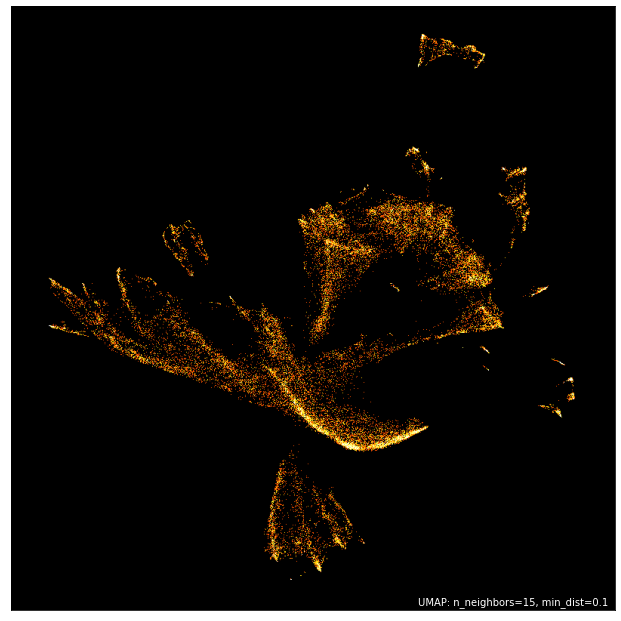

In [82]:
umap_fig = umap.plot.points(reducer, theme="fire")
umap.plot.show(umap_fig)

## Fetch N Most Similar Articles

In [189]:
n_most_similar = [
    model.wv.most_similar(article_id, topn=500) for article_id in tqdm(article_ids)
]

100%|█| 87274/872


In [191]:
df_n_most_similar = pd.DataFrame(
    {"article_id": article_ids, "n_most_similar": n_most_similar}
).explode("n_most_similar")

df_n_most_similar = pd.DataFrame(
    df_n_most_similar["n_most_similar"].tolist(),
    columns=["similar_article_id", "score"],
    index=df_n_most_similar["article_id"],
)

<AxesSubplot:ylabel='Frequency'>

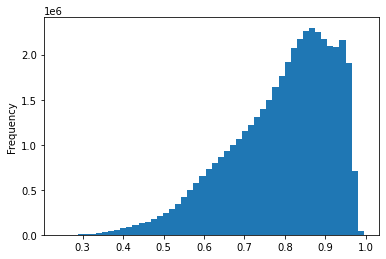

In [193]:
df_n_most_similar["score"].plot.hist(bins=50)

In [198]:
df_n_most_similar.memory_usage(index=True).sum()

1047288000

In [199]:
df_n_most_similar.reset_index().to_gbq(
    "zenscr-seefood-dev.hm_kaggle_reco.misc_similar_articles",
    project_id="zenscr-seefood-dev",
    if_exists="replace",
    progress_bar=True,
)

1


## Evaluate

In [200]:
%%bigquery df_num_candidates --project zenscr-seefood-dev

SELECT
  dates.obs_dat,
  customer_id,
  COUNT(DISTINCT sim.similar_article_id) AS num_candidates
FROM `zenscr-seefood-dev.hm_kaggle_reco.feat_base_dates` dates
LEFT JOIN `zenscr-seefood-dev.hm_kaggle.transactions` AS trans
      ON dates.t_dat = trans.t_dat AND trans.t_dat >= DATE_SUB(obs_dat, INTERVAL 365 DAY)
LEFT JOIN `zenscr-seefood-dev.hm_kaggle_reco.misc_similar_articles` AS sim
      ON CAST(trans.article_id AS STRING) = sim.article_id AND sim.score > 0.6
WHERE obs_dat = "2020-04-01"
GROUP BY obs_dat, customer_id

Query complete af
Downloading: 100%


In [201]:
df_num_candidates

,obs_dat,customer_id,num_candidates
0,2020-04-01,307f7cee90f15d15aa382d0ec662040fca3277fd34a7f9...,6496
1,2020-04-01,6a20f26f380f64575d7d7bf1240d9276d4599de70f5dec...,3993
2,2020-04-01,48ffe60e4f07bbbf8d932670b24fc4b29688da6645f639...,2581
3,2020-04-01,dfa43f334de21595afd342b056a16b47c1bf544b4e03d0...,741
4,2020-04-01,9e8b426781e7979ff883f1bfd4644016a727e7658f0549...,4975
...,...,...,...
966483,2020-04-01,43cc1a3c9d2e2e44ebdddc42ca1013e87aa3ff80dc710f...,500
966484,2020-04-01,989da11f1eb11a0275e2fa277f4b25a6919799d56b820c...,63
966485,2020-04-01,d3a7c9ce733884b3f5422e611383360f21f508e3d5f578...,66
966486,2020-04-01,d01b8971095b074665d6b6e9e060926653dc59308ac545...,35


<AxesSubplot:ylabel='Frequency'>

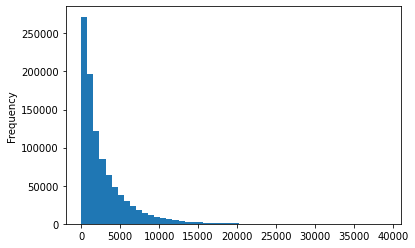

In [202]:
df_num_candidates["num_candidates"].plot.hist(bins=50)

In [203]:
df_num_candidates["num_candidates"].describe()

count   966488.00
mean      2744.31
std       3049.10
min          0.00
25%        679.00
50%       1644.00
75%       3704.00
max      39073.00
Name: num_candidates, dtype: float64

In [204]:
df_num_candidates[df_num_candidates["num_candidates"] == 0]

,obs_dat,customer_id,num_candidates
13415,2020-04-01,c7b7b595098568136e405aea2eafa21b20484615690a5a...,0
64131,2020-04-01,0a0c45abb4ad7aeaaf4dc14f0632838a3f9030d06b2a51...,0
78143,2020-04-01,130fa86367de4876c8a16f4b71438452c3a2e459340873...,0
81513,2020-04-01,eea611322e40ecc5a0346c6520695b2f0a6d3a0cf0e641...,0
98761,2020-04-01,fbc363e1135fed80301b019f1dbbed2745f1200a239429...,0
118270,2020-04-01,c73bcda88fb2d50992c4a6303c9f7629099c8d51f5cac7...,0
141003,2020-04-01,924f4f5345a80b854d02dfa70eeaaaee7591748856d932...,0
151668,2020-04-01,e84e8e5ba155e3dee7c9f969daa16c91079ac0a47b2215...,0
214078,2020-04-01,eba106f0816218c819fb865d8bb45490bb52372c8d5921...,0
247500,2020-04-01,356bbb456e6e672075fcdfb224904dd9ba6b482c6017b7...,0


In [ ]:
WITH gt_and_neg AS (
  SELECT 
    obs_dat,
    customer_id,
    article_id,
    -1.0 AS score,
    relevance
  FROM `zenscr-seefood-dev.hm_kaggle_reco.ground_truth`
  UNION ALL
  SELECT
    obs_dat,
    customer_id,
    article_id,
    score,
    relevance
  FROM `zenscr-seefood-dev.hm_kaggle_reco.cand_article_similarity`
)
SELECT
    obs_dat,
    customer_id,
    article_id,
    MAX(score) AS score,
    MAX(relevance) AS relevance
FROM gt_and_neg
GROUP BY obs_dat, customer_id, article_id
